## COSC 189 Final Project ##

### Online Speech Patterns Based on Mental Health Disorders ###

#### Ivory Yang ####


**Introduction**

In this project, we delve into the intricate relationship between mental health disorders and online communication patterns. The digital realm, particularly Reddit forums dedicated to mental health issues such as depression, bipolar disorder, personality disorder, and anxiety, serves as a unique platform where individuals express their thoughts and emotions. The primary objective is to analyze a comprehensive dataset of Reddit comments from these specific forums and compare them against a control dataset. By doing so, we aim to discern potential distinctions in the linguistic characteristics of individuals based on their self-identified mental health conditions. This exploration sheds light on how mental health disorders may manifest in the online discourse, offering valuable insights into the intersection of digital communication and psychological well-being.


**Data**

This project's dataset, sourced from Kaggle, encompasses over 5000 entries extracted from Reddit by a previous researcher before the Reddit API regulations change. These comments are thoughtfully distributed across four distinct mental health disorders: Depression (1), Bipolar Disorder (2), Avoidant Personality Disorder (3), and Anxiety (4). Each group is equally represented, allowing for a robust examination of online communication within these specific mental health forums. Additionally, a Control Group (0) is included, serving as a benchmark for comparative analysis. This well-organized dataset forms the foundation for investigating potential linguistic variations among individuals with different self-identified mental disorders and those in the control group, contributing to a nuanced understanding of the intersection between online discourse and mental health.


In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


# load data into dataframe
df = pd.read_csv('data_to_be_cleansed 2.csv')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ivoryang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ivoryang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [13]:
# Key: 1 = Depression, 2 = Bipolar Disorder, 3 = Avoidant Personality Disorder, 4 = Anxiety, 0 = Control Group
df

,Unnamed: 0,text,title,target
0,0,Welcome to /r/depression's check-in post - a p...,"Regular check-in post, with information about ...",1
1,1,We understand that most people who reply immed...,Our most-broken and least-understood rules is ...,1
2,2,Anyone else just miss physical touch? I crave ...,"I haven’t been touched, or even hugged, in so ...",1
3,3,I’m just so ashamed. Everyone and everything f...,Being Depressed is Embarrassing,1
4,4,I really need a friend. I don't even have a si...,I'm desperate for a friend and to feel loved b...,1
...,...,...,...,...
5952,1183,I’ve (24M) dealt with depression/anxiety for y...,Nobody takes me seriously,4
5953,1184,"""I don't feel very good, it's like I don't be...",selfishness,4
5954,1185,"I can't sleep most of the nights, meds didn't ...",Is there any way to sleep better?,4
5955,1186,"Hi, all. I have to give a presentation at work...",Public speaking tips?,4


**Methodology: Data Clean Up**

The dataset is processed and cleaned for use. Unnecessary columns ('Unnamed: 0' and 'title') are removed, and columns are renamed to enhance clarity, transforming 'text' into 'User Comments' and 'target' into 'Category.' The DataFrame is sorted and, if necessary, its index is reset. A mapping is established to replace numerical category values with their corresponding mental health disorder names. A function is defined to extract the middle 1000 entries for each category, ensuring a balanced representation. This function is then applied to the dataframe, and the resulting output is a 5000 rows x 2 columns dataset that has 1000 user comment entries each for the control group and the four mental disorders.


In [14]:
# Remove unnecessary columns
columns_to_remove = ['Unnamed: 0', 'title']
df = df.drop(columns=columns_to_remove, errors='ignore')  # Use errors='ignore' to avoid errors if columns are not found

# Rename columns
new_column_names = {
    'text': 'User Comments',
    'target': 'Category',
}
df = df.rename(columns=new_column_names)


# Sort the DataFrame based on the 'Category' column
df_sorted = df.sort_values(by='Category')

# Reset the index if needed
df_sorted = df_sorted.reset_index(drop=True)


# Define a mapping from numerical categories to their names
category_mapping = {
    0: 'Control',
    1: 'Depression',
    2: 'Bipolar Disorder',
    3: 'Avoidant Personality Disorder',
    4: 'Anxiety',
}

# Replace numerical values in the 'Category' column with words
df_sorted['Category'] = df_sorted['Category'].replace(category_mapping)


# Function to get the middle 1000 entries for each category
def get_middle_entries(group):
    middle_index = len(group) // 2
    return group.iloc[middle_index - 500: middle_index + 500]

# Apply the function to each category / mental disorder
result_df = df_sorted.groupby('Category', group_keys=False, sort=False).apply(get_middle_entries)

# Reset the index if needed
result_df = result_df.reset_index(drop=True)

# Print the resulting DataFrame with the middle 1000 entries for each category
print("\nDataFrame with middle 1000 entries for each category:")
print(result_df)




DataFrame with middle 1000 entries for each category:
                                          User Comments Category
0     I’ve been applying to  multiple universities a...  Control
1     I'm trying to learn blender and unity and Lua ...  Control
2     Here are some ways to treat anxiety and depres...  Control
3     All my family keeps telling me oh it’s acid re...  Control
4      \n\nFear is a normal emotion that every human...  Control
...                                                 ...      ...
4995  TW: discussion of anxiety symptoms \n\nSome co...  Anxiety
4996  I (23) F have never been pulled over or given ...  Anxiety
4997  What helps you stay in the present? All day to...  Anxiety
4998  I just wanted to rant in a sort of way.  I jus...  Anxiety
4999  I was supposed to go to a pub crawl event this...  Anxiety

[5000 rows x 2 columns]


In [15]:
result_df

,User Comments,Category
0,I’ve been applying to multiple universities a...,Control
1,I'm trying to learn blender and unity and Lua ...,Control
2,Here are some ways to treat anxiety and depres...,Control
3,All my family keeps telling me oh it’s acid re...,Control
4,\n\nFear is a normal emotion that every human...,Control
...,...,...
4995,TW: discussion of anxiety symptoms \n\nSome co...,Anxiety
4996,I (23) F have never been pulled over or given ...,Anxiety
4997,What helps you stay in the present? All day to...,Anxiety
4998,I just wanted to rant in a sort of way. I jus...,Anxiety


**Methodology: Data Processing**

After cleaning and sorting the dataset, we further focus on refining the textual data within the dataset through tokenization and text cleaning. Utilizing the NLTK library, the 'User Comments' column is tokenized into individual words, ensuring a more granular analysis of the linguistic content. To enhance the quality of the text, a cleaning function is applied, wherein each word is converted to lowercase, and words with fewer than three characters or those containing non-alphanumeric characters are removed. This systematic approach ensures that the dataset's textual information is standardized, facilitating subsequent analyses that rely on the linguistic nuances of the user comments.


In [16]:
# Tokenize text, lowercasing, removing words < 3 characters and non-alnum

from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')  # Download the punkt tokenizer if not already downloaded

comments_column = 'User Comments'

# Check for NaN values and replace with an empty string or another appropriate value
result_df[comments_column] = result_df[comments_column].fillna('')  # Replace NaN with an empty string

# Tokenize the text using nltk's word_tokenize
result_df[comments_column] = result_df[comments_column].apply(word_tokenize)

def clean_text(tokens):
    return [word.lower() for word in tokens if len(word) > 2 and word.isalnum()]

# Apply the cleaning function to the 'user_comments' column
result_df[comments_column] = result_df[comments_column].apply(clean_text)


[nltk_data] Downloading package punkt to /Users/ivoryang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [17]:
result_df

,User Comments,Category
0,"[been, applying, multiple, universities, and, ...",Control
1,"[trying, learn, blender, and, unity, and, lua,...",Control
2,"[here, are, some, ways, treat, anxiety, and, d...",Control
3,"[all, family, keeps, telling, acid, reflux, yo...",Control
4,"[fear, normal, emotion, that, every, human, ex...",Control
...,...,...
4995,"[discussion, anxiety, symptoms, some, context,...",Anxiety
4996,"[have, never, been, pulled, over, given, traff...",Anxiety
4997,"[what, helps, you, stay, the, present, all, da...",Anxiety
4998,"[just, wanted, rant, sort, way, just, got, fin...",Anxiety


In [18]:
# Gather all the tokenized cleaned text in each category
result_df[comments_column] = result_df[comments_column].apply(' '.join)


In [19]:
result_df

,User Comments,Category
0,been applying multiple universities and always...,Control
1,trying learn blender and unity and lua and rea...,Control
2,here are some ways treat anxiety and depressio...,Control
3,all family keeps telling acid reflux your anxi...,Control
4,fear normal emotion that every human experienc...,Control
...,...,...
4995,discussion anxiety symptoms some context strug...,Anxiety
4996,have never been pulled over given traffic tick...,Anxiety
4997,what helps you stay the present all day today ...,Anxiety
4998,just wanted rant sort way just got finished wi...,Anxiety


**Analysis: TF-IDF**

Initially, the tokenized and cleaned text within each mental health category is systematically aggregated, offering a consolidated representation of the linguistic nuances present in user comments. Subsequently, the Term Frequency-Inverse Document Frequency (TF-IDF) vectorizer is applied. Configured with a maximum of 1000 features, this vectorizer assigns numerical weights to words based on their significance in each category, thereby capturing the distinctive language patterns inherent to discussions surrounding depression, bipolar disorder, avoidant personality disorder, anxiety, and the control group. This step not only refines the dataset but also provides a quantitative foundation for the subsequent dimensionality reduction.


In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Initialize the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # Adjust max_features as needed

# Fit and transform the TF-IDF vectorizer
tfidf_matrix = tfidf_vectorizer.fit_transform(result_df[comments_column])


**Analysis: t-SNE Plot**

We then apply the dimensionality reduction technique: t-distributed Stochastic Neighbor Embedding (t-SNE). Executed with parameters such as a perplexity of 4 and 300 iterations, t-SNE transforms the TF-IDF matrix into two dimensions. This reduction facilitates the creation of a visually compelling representation of the textual landscape using a scatter plot. In this plot, each point signifies a Reddit comment, strategically colored to denote its associated mental health category. This intuitive visualization allows for a nuanced exploration of the interplay between mental health categories and linguistic patterns, shedding light on potential clusters or disparities within the online discussions.


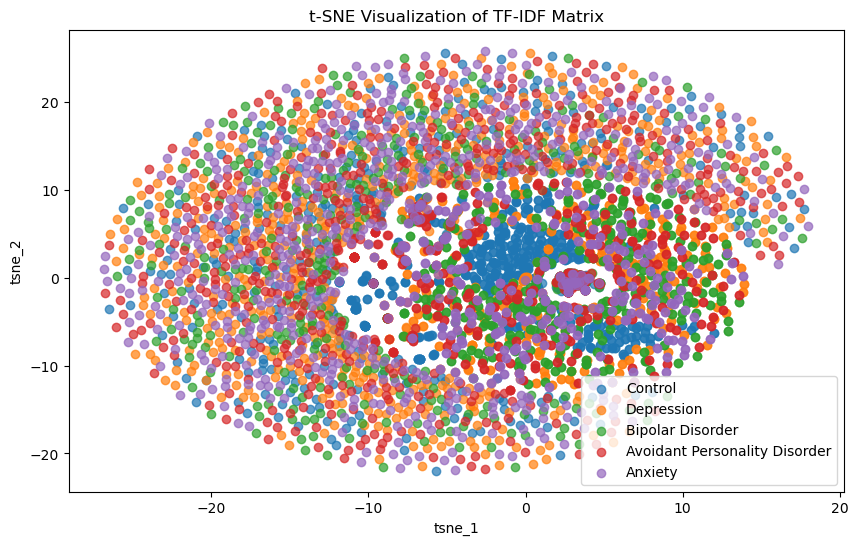

In [21]:
category_column = 'Category'

# Apply t-SNE to reduce the dimensionality
tsne = TSNE(n_components=2, perplexity=4, n_iter=300, init='random', random_state=42)  # Adjust perplexity and n_iter as needed
tsne_result = tsne.fit_transform(tfidf_matrix)

# Create a DataFrame with the t-SNE result and mental health categories
tsne_df = pd.DataFrame(tsne_result, columns=['tsne_1', 'tsne_2'])
tsne_df[category_column] = result_df[category_column]

# Plot the t-SNE result
plt.figure(figsize=(10, 6))
for category in tsne_df[category_column].unique():
    category_data = tsne_df[tsne_df[category_column] == category]
    plt.scatter(category_data['tsne_1'], category_data['tsne_2'], label=category, alpha=0.7)

plt.title('t-SNE Visualization of TF-IDF Matrix')
plt.xlabel('tsne_1')
plt.ylabel('tsne_2')
plt.legend()
plt.show()

**Interpretation of Results**

The t-SNE visualization of the TF-IDF matrix reveals a distinctive oval shape with no discernible separation of clusters, except for the control group, which somewhat concentrates in the center. The absence of clear cluster boundaries suggests that the linguistic patterns within the mental health forums exhibit a considerable degree of overlap, making it challenging to distinguish distinct groups based solely on the linguistic features analyzed. The pronounced concentration of the control group in the central region indicates a more homogeneous distribution of linguistic characteristics, possibly reflecting a comparatively neutral or diverse linguistic expression within this category. These results underscore the complexity of language use in online mental health forums, where diverse linguistic patterns coalesce, and further investigation may be warranted to explore the nuanced interactions between linguistic expression and mental health discussions within this digital space.


**Potential Improvements to be Implemented**

In light of the t-SNE graph displaying an oval shape with limited cluster separation, it's worth considering additional steps to enhance the visualization. Firstly, experimenting with different hyperparameters of the t-SNE algorithm, such as adjusting perplexity, learning rate, and the number of iterations, may offer insights into more distinct clustering patterns. Additionally, fine-tuning the TF-IDF vectorizer parameters, including the maximum number of features and the inclusion of n-grams, could impact the feature representation. Exploring alternative dimensionality reduction techniques or ensemble methods might provide a fresh perspective on the dataset. Moreover, incorporating sentiment analysis or other linguistic features may contribute to a more nuanced understanding of the underlying patterns. Lastly, considering a stratified sampling approach during the dataset preparation phase could address potential imbalance issues among mental health categories. These iterative refinements, coupled with a thoughtful exploration of parameters, should be undertaken to iteratively improve the t-SNE visualization and reveal subtler linguistic patterns within the diverse landscape of online mental health discussions.

**Limitations**

While this project offers valuable insights into the relationship between mental health forums on Reddit and the linguistic characteristics of user comments, it is essential to acknowledge certain limitations. Firstly, the dataset's reliance on self-reported diagnoses within each forum introduces the possibility of misclassification or misrepresentation, as users may not be professionally diagnosed or may have multiple mental health concerns. Additionally, the dataset's focus on English language comments from specific forums may not capture the full spectrum of mental health discussions, limiting generalizability.

Moreover, the tokenization and cleaning process, though comprehensive, may inadvertently exclude certain linguistic nuances or expressions, impacting the accuracy of the subsequent analyses. The use of TF-IDF, while effective in highlighting keyword importance, may not fully capture the context or sentiment of user comments. Furthermore, the t-SNE visualization, while providing a compelling two-dimensional representation, inherently involves a degree of subjectivity in parameter selection, potentially influencing the interpretation of results.

Finally, it's crucial to note that the online environment evolves rapidly, and the dataset's static nature may not fully capture temporal changes or emerging trends in online mental health discussions. Despite these limitations, this project lays a solid foundation for understanding the linguistic landscape of mental health forums, serving as a stepping stone for more nuanced and comprehensive investigations into the intersection of mental health and online communication.


**Significance of Analysis**


This project holds significant importance in the broader context of mental health research and online communication analysis. As society becomes increasingly interconnected through digital platforms, understanding how individuals express and cope with mental health concerns in online forums is crucial. By examining user comments from Reddit forums dedicated to mental health issues, this project not only contributes to the growing body of knowledge surrounding mental health discourse but also offers insights into the unique dynamics of online support communities.

The findings from this project have the potential to inform mental health professionals, researchers, and platform administrators about the distinct ways individuals communicate about their mental well-being in online spaces. Recognizing the linguistic patterns associated with different mental health disorders could pave the way for improved online mental health interventions, personalized support systems, and targeted resources. Additionally, by shedding light on the intersection of language and mental health, this project may contribute to reducing stigma, fostering empathy, and promoting a deeper understanding of the diverse ways individuals express their struggles and seek support in the digital age. In essence, this research extends beyond the technicalities of data analysis, serving as a stepping stone toward enhancing our comprehension of the intricate relationship between mental health and online communication on a societal scale.


**Conclusion**


In conclusion, this project delves into the intricate landscape of mental health discourse within online communities, specifically focusing on Reddit forums dedicated to depression, bipolar disorder, personality disorder, anxiety, and a control group. Through meticulous data preprocessing, including column removal, renaming, sorting, and cleaning of textual content, the dataset is refined for meaningful analysis. The subsequent application of advanced techniques such as TF-IDF vectorization and t-SNE dimensionality reduction provides a unique lens through which to examine the linguistic patterns associated with different mental health categories.

While the project acknowledges certain limitations, including potential misclassification, linguistic nuances, and the dynamic nature of online discourse, it represents a crucial step toward unraveling the complexities of mental health communication in the digital age. Beyond the technicalities, the significance of this research lies in its potential to inform mental health interventions, reduce stigma, and contribute to a deeper understanding of how individuals articulate and navigate their mental health journeys in online spaces. As the digital landscape continues to shape the way we connect and share experiences, this project stands at the intersection of technology and mental health, offering valuable insights that may pave the way for more informed, empathetic, and supportive online communities.
